# Deformation Transfer

In [2]:
import igl
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg import splu
from scipy.sparse import lil_matrix
from easydict import EasyDict

from collections import defaultdict

from matplotrender import *
from utils.ict_face_model import ICT_face_model

In [3]:


def rescale(V1 ,V2):
    """rescale V1 to V2"""
    V1mean = (V1.max(0)+V1.min(0))*0.5
    V2mean = (V2.max(0)+V2.min(0))*0.5
    V = (V1-V1mean)/max(V1.max(0)-V1.min(0)) * max(V2.max(0)-V2.min(0)) + V2mean
    return V

def get_centroids(x):
    L = x.shape[0]
    return x.sum(0) / (L+1)

def get_vertex_normal(VF):
    E1 = VF[:,1] - VF[:,0]
    E2 = VF[:,2] - VF[:,0]

    Vn = np.cross(E1, E2)
    Vn = Vn / np.linalg.norm(Vn, axis=-1)[:,None]
    return Vn

def get_triangle_basis(V,F):
    VF = V[F]
    E1 = VF[:,1] - VF[:,0]
    E2 = VF[:,2] - VF[:,0]

    # Vn = np.cross(E1, E2)
    # Vn = Vn/np.linalg.norm(Vn, axis=-1)[:,None]
    Vn = get_vertex_normal(VF)
    
    # V4 = Vn + VF[:,0]
    # returns [V2-V1, V3-V1, V4-V1]
    return np.stack([E1, E2, Vn], axis=1).transpose(0,2,1)
    
def lu_factor_ata(A):
    AtA = A.T @ A
    lu = splu(AtA.tocsc())
    return lu
    
def creat_A_csr_matrix(V, F, INV_MAT):
    rows = []
    cols = []
    data = []

    T = F.shape[0]
    N = V.shape[0]

    # T (num triangle) x 3 (v indicies) x 3 (xyz coordinates)
    INV_MAT = INV_MAT.transpose(0,2,1)
    COEFF = np.concatenate((
            -INV_MAT[:, :, 0:2].sum(-1, keepdims=True), 
            INV_MAT[:, :, 0:2]
        ), axis = -1)
                    
    R_=3
    C_=3
    for i, H in enumerate(COEFF): # foreach T
        # H : coeff mat 3x3            
        for r in range(R_):
            for c in range(C_): # foreach xyz
                for k, v_j in enumerate(F[i]): 
                    # v_j: vertex indicies in triangle
                    # k: num indicies (0, 1, 2)
                    cols.append(C_*v_j+c)
                    rows.append(9*i+R_*r+c)                
                    data.append(H[r,k])
                    
    return sp.csr_matrix((data, (rows, cols)), shape=(T * 3 * R_, N * C_))

def creat_A_csr_matrix_34(V, F, INV_MAT):
    rows = []
    cols = []
    data = []

    T = F.shape[0]
    N = V.shape[0]

    # T (num triangle) x 3 (v indicies) x 3 (xyz coordinates)
    INV_MAT = INV_MAT.transpose(0,2,1)
    COEFF = np.concatenate((
            -INV_MAT.sum(-1, keepdims=True), 
            INV_MAT
        ), axis = -1)
    
    R_=3
    C_=3
    for i, H in enumerate(COEFF): # foreach T
        # H : coeff mat 3x3
        for r in range(R_):
            for c in range(C_): # foreach xyz+d
                for k, v_j in enumerate(F[i]): 
                    # v_j: vertex indicies in triangle
                    # k: num indicies (0, 1, 2)
                    cols.append(C_*v_j+c)
                    rows.append(9*i+R_*r+c)                
                    data.append(H[r,k])
            
                # for [V4-V1]
                cols.append(C_*N + c + 3*i)
                rows.append(9*i + R_*r + c)
                data.append(H[r, 3])

    MAT = sp.csr_matrix((data, (rows, cols)), shape=(3 * R_ * T, (C_ * N) + (C_ * T)))

    return MAT


def build_edge_to_tri_map(F):
    """
    Args:
        F: (F, 3) 배열
        
    Returns: 
        (dict) { (min(v1,v2), max(v1,v2)): [tri_idx1, tri_idx2, ...], ... }
    """
    
    edge2tri = defaultdict(list)
    for i, tri in enumerate(F):
        v0, v1, v2 = tri
        edges = [
            tuple(sorted((v0, v1))),
            tuple(sorted((v1, v2))),
            tuple(sorted((v2, v0)))
        ]
        for e in edges:
            edge2tri[e].append(i)
    return edge2tri

def get_edge_adj_matrix(F):
    edge2tri = build_edge_to_tri_map(F)

    T = len(F)
    mat = np.zeros((T, T), dtype=int)

    # Find adjacent triangle j for each triangle i
    for i, tri in enumerate(F):
        adj_set = set()
        v0, v1, v2 = tri
        edges = [
            tuple(sorted((v0, v1))),
            tuple(sorted((v1, v2))),
            tuple(sorted((v2, v0)))
        ]
        for e in edges:
            for nbr_tri in edge2tri[e]:
                if nbr_tri != i:
                    adj_set.add(nbr_tri)

        mat[i, i] = len(adj_set)
        for j in adj_set:
            mat[i, j] = -1

    return mat


def get_adj_triangle_mat_edge_sparse(F):

    edge2tri = build_edge_to_tri_map(F)
    T = len(F)
    mat = lil_matrix((9*T, 9*T), dtype=int)

    for i, tri in enumerate(F):
        adj_set = set()
        v0, v1, v2 = tri
        edges = [
            tuple(sorted((v0, v1))),
            tuple(sorted((v1, v2))),
            tuple(sorted((v2, v0)))
        ]
        for e in edges:
            for nbr_tri in edge2tri[e]:
                if nbr_tri != i:
                    adj_set.add(nbr_tri)

        mat[9*i:9*i+9, 9*i:9*i+9] = len(adj_set)*np.eye(9)
        for j in adj_set:
            mat[9*i:9*i+9, 9*j:9*j+9] = -1*np.eye(9)
    return mat.tocsr()


## Example code to create A matrix

In [ ]:
   
#V, F, INV_MAT = np.random.rand((5,3)), np.random.randint(1,5,(4,3))
V = np.random.randint(0,20,(6,1)).repeat(3,1)
# V = np.random.randint(0,3,(3,3))
# F = np.array([[0,1,2]])
# F = np.array([[0,2,3],[1,2,5],[0,4,5]])
F = np.array([[0,2,3],[1,2,5]])
# F = np.array([[0,1,2],[0,2,3],[0,3,1],[1,3,2]])

T=F.shape[0]
N=V.shape[0]
INV_MAT = np.random.randint(0,20,(T,4,3))

In [28]:
V

array([[19, 19, 19],
       [11, 11, 11],
       [ 6,  6,  6],
       [ 0,  0,  0],
       [15, 15, 15],
       [13, 13, 13]])

In [ ]:
rows = []
cols = []
data = []

T = F.shape[0]
N = V.shape[0]

print("num T:", T)
print("num N:", N)

# T (num triangle) x 3 (v indicies) x 3 (xyz coordinates)
COEFF = INV_MAT.transpose(0,2,1)
# COEFF = np.concatenate((
#         -INV_MAT.sum(-1, keepdims=True), 
#         INV_MAT[:, :, 0:2]
#     ), axis = -1)

R_=3
C_=3

#VN = get_vertex_normal(V[F])

for i, H in enumerate(COEFF): # foreach T
    # H : coeff mat 3x3
    print(H)
        
    for r in range(R_):
        for c in range(C_): # foreach xyz+d
            for k, v_i in enumerate(F[i]): 
                # v_i: v indicies
                # k: num indicies (0, 1, 2)
                cols.append(C_*v_i+c)
                rows.append(9*i+R_*r+c)                
                data.append(H[r,k])
        
            # for V4 
            cols.append(3*i+C_*N+c)
            rows.append(9*i+R_*r+c)
            data.append(H[r, 3])

MAT = sp.csr_matrix((data, (rows, cols)), shape=(3 * R_ * T, (C_ * N) + (C_ * T)))

print(MAT.todense().astype(int))
# np.savetxt('test.txt', MAT.todense().astype(int))   # X is an array
print(V.reshape(-1)[None])


num T: 2
num N: 6
[[19 17  8  8]
 [17  3 12  2]
 [11  9 13  4]]
[[ 3 12  8  0]
 [ 2 18 19  9]
 [ 6  6  7 14]]
[[19  0  0  0  0  0 17  0  0  8  0  0  0  0  0  0  0  0  8  0  0  0  0  0]
 [ 0 19  0  0  0  0  0 17  0  0  8  0  0  0  0  0  0  0  0  8  0  0  0  0]
 [ 0  0 19  0  0  0  0  0 17  0  0  8  0  0  0  0  0  0  0  0  8  0  0  0]
 [17  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0]
 [11  0  0  0  0  0  9  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  9  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  9  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0 

In [ ]:
def look_triangle_has_v(vtx_idx, tri_idx, F):
    holds = []
    for idx, triangle in enumerate(F[:tri_idx]):
        for vidx in triangle:
            if vtx_idx == vidx:
                holds.append(idx)
                
    for idx, triangle in enumerate(F[tri_idx+1:]):
        for vidx in triangle:
            if vtx_idx == vidx:
                holds.append(idx+tri_idx+1)
    return holds

In [250]:
# mat={idx:[] for idx in range(len(V))}
def get_adj_triangle_mat(F):
    mat = np.zeros([len(F), len(F)])
    # print(mat.shape)

    for i in range(len(F)):
        js=[]
        for vidx in F[i]:
            j_list = look_triangle_has_v(vidx, i, F)
            # print(i, F[i], vidx, j_list)
            js += j_list
        js = list(set(js))
        mat[i,i] = len(js)
        mat[i, js] = -1
    return mat
# print(mat)
    

In [58]:

F = np.array([[0,1,2],[0,2,3],[0,3,1],[1,3,2]])

In [66]:
adjF = get_edge_adj_matrix(F)
print(adjF[:3, :12])

[[ 3 -1 -1 -1]
 [-1  3 -1 -1]
 [-1 -1  3 -1]]


In [86]:
adjF = get_adj_triangle_mat_edge_sparse(F)
print(adjF.shape)
print(adjF[:15, :15].todense())

(36, 36)
[[ 3  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0 -1  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  0 -1  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0 -1  0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0 -1  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  3]]


### save as textfile to check if it is right!

In [246]:
np.savetxt('test.txt', A.todense())   # X is an array


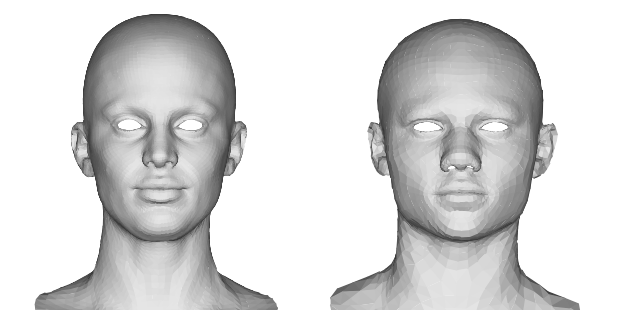

In [4]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .7

srcV, srcF = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
newV, newF = igl.read_triangle_mesh("data/target_restpose_mesh.obj")

v_list=[ srcV, newV ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ srcF, newF ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [5]:
# source rest pose
V_S = get_triangle_basis(srcV, srcF)
V_S_INV = np.linalg.inv(V_S)
print(V_S_INV.shape)

As = creat_A_csr_matrix_34(srcV, srcF, V_S_INV)
print("A shape (9T x 3N+3T)", As.shape)
lu = lu_factor_ata(As)

adjM = get_adj_triangle_mat_edge_sparse(srcF)
A_Es=adjM @ As

(22288, 3, 3)
A shape (9T x 3N+3T) (200592, 100608)


In [6]:
# def build_smooth_optimization_term(V_span, F, adjF, A, ws=1):
V_span, F, adjF, A = V_S, srcF, adjM, As
ws=1
# num of src mesh faces
num_f = len(F)
# build a [3f, 3f] Identity matrix
id_mat_3fby3f = sp.identity(n=9 * num_f, format='csc')
print(id_mat_3fby3f.shape)
print(adjF.shape)

# build the left-side (input) matrix of the linear equation, it's a [n, n] mat
mat_tmp = (id_mat_3fby3f - adjF).dot(A)
left_mat = (mat_tmp.transpose()).dot(mat_tmp)
# build the right-side (target) matrix of the linear equation, it's a all-zero matrix with shape [n, 3]
np_row, np_col, np_val = np.array([]), np.array([]), np.array([])
right_mat = sp.csc_matrix((np_val, (np_row, np_col)), shape=(len(V_span), 3))
# build the weight matrix
ws_mat = sp.identity(n=len(V_span), format='csc').multiply(2.0 * ws)
    # return left_mat, right_mat, ws_mat

(200592, 200592)
(200592, 200592)


In [7]:
left_mat.todense()

MemoryError: Unable to allocate 75.4 GiB for an array with shape (100608, 100608) and data type float64

In [96]:
left_mat, right_mat, ws_mat = build_smooth_optimization_term(V_S, srcF, adjM, As, ws=1)

ValueError: inconsistent shapes

In [49]:
# adjM = get_adj_triangle_mat(srcF)
adj = get_edge_adj_matrix(srcF)
print(adj.shape)
print(adj[0:3, :6])

(22288, 22288)
[[ 3 -1  0  0  0  0]
 [-1  3  0  0  0  0]
 [ 0  0  3  0  0  0]]


In [87]:
adjM = get_adj_triangle_mat_edge_sparse(srcF)

In [88]:
print(adjM.shape)
print(adjM[0:3, :12].todense())

(200592, 200592)
[[ 3  0  0  0  0  0  0  0  0 -1  0  0]
 [ 0  3  0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  3  0  0  0  0  0  0  0  0 -1]]


In [89]:
A_Es=adjM @ As

In [90]:
A_Es.shape

(200592, 100608)

## Load meshes

In [92]:
## loading blendshape
ict = ICT_face_model()
blendshapes = ict.exp_basis[:,:11248]
BS = 27
print(blendshapes.shape)


tgt_mesh = EasyDict()
src_mesh = EasyDict()

print('loading meshes')
src_mesh.v, src_mesh.f = igl.read_triangle_mesh("_tmp/m02_model.obj")
# src_mesh.v, src_mesh.f = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
# src_mesh.v, src_mesh.f = ict.neutral_verts, ict.faces
print('\t src vertices:', src_mesh.v.shape, '\t faces:',src_mesh.f.shape) # (11248, 3) (22288, 3)

src_mesh.motions = blendshapes[BS]#np.load(r'_tmp\040.npy')
print('\t src vertices (posed):', src_mesh.motions.shape) # (219, 11248, 3)

newV, newF = igl.read_triangle_mesh("_tmp/m02_deformed-0.2.obj")
# newV, newF = igl.read_triangle_mesh("data/target_restpose_mesh.obj")
newV = rescale(newV, src_mesh.v)
tgt_mesh.v = newV
tgt_mesh.f = src_mesh.f
print('\t tgt vertices:', tgt_mesh.v.shape) # (219, 11248, 3)



# target rest pose
V_T = get_triangle_basis(tgt_mesh.v, tgt_mesh.f)
V_T_INV = np.linalg.inv(V_T)
print(V_T_INV.shape)

A = creat_A_csr_matrix_34(tgt_mesh.v, tgt_mesh.f, V_T_INV)
# A = creat_A_csr_matrix(tgt_mesh.v, tgt_mesh.f, V_T_INV)
print("A shape", A.shape)
lu = lu_factor_ata(A)

(53, 11248, 3)
loading meshes
	 src vertices: (11248, 3) 	 faces: (22288, 3)
	 src vertices (posed): (11248, 3)
	 tgt vertices: (11248, 3)
(22288, 3, 3)
A shape (200592, 100608)


## Run

In [94]:
# source rest pose ########################
V_S = get_triangle_basis(src_mesh.v, src_mesh.f)
print(V_S.shape) # (22288, 3, 3)
###########################################

# source posed ############################
#FRAME = 150
# V_S_H = get_triangle_basis(src_mesh.motions[FRAME], src_mesh.f)
# BS = 11
BS = 26
V_S_H = get_triangle_basis(blendshapes[BS]+src_mesh.v, src_mesh.f)
print(V_S_H.shape) # (22288, 3, 3)
###########################################

## a.k.a source transformation `S = V^~ @ V^-1`
V_S_INV = np.linalg.inv(V_S)
S = V_S_H @ V_S_INV
print(S.shape) # (22288, 3, 3)
###########################################


# target rest pose ########################
V_T = get_triangle_basis(tgt_mesh.v, tgt_mesh.f)
V_T_INV = np.linalg.inv(V_T)
print(V_T_INV.shape)
###########################################


# A^T A x^~ = A^T c
# x^~ = (A^T A)^-1 A^T c

Atb = A.T @ S.transpose(0,2,1).reshape(-1)
print(S.shape)
print(Atb.shape)

V_transferred = lu.solve(Atb).reshape(-1,3)
# print(V_transferred.shape)
V_transferred = V_transferred[:tgt_mesh.v.shape[0]]
# print(V_transferred.shape)

recenter = -V_transferred.mean(0)+tgt_mesh.v.mean(0)

# V_transferred = rescale(V_transferred, src_mesh.v)
# print(src_mesh.v.min(0), src_mesh.v.max(0))
# print(src_mesh.motions[FRAME].min(0), src_mesh.motions[FRAME].max(0))
# print(tgt_mesh.v.min(0), tgt_mesh.v.max(0))
# print(V_transferred.min(0), V_transferred.max(0))



(22288, 3, 3)
(22288, 3, 3)
(22288, 3, 3)
(22288, 3, 3)
(22288, 3, 3)
(100608,)


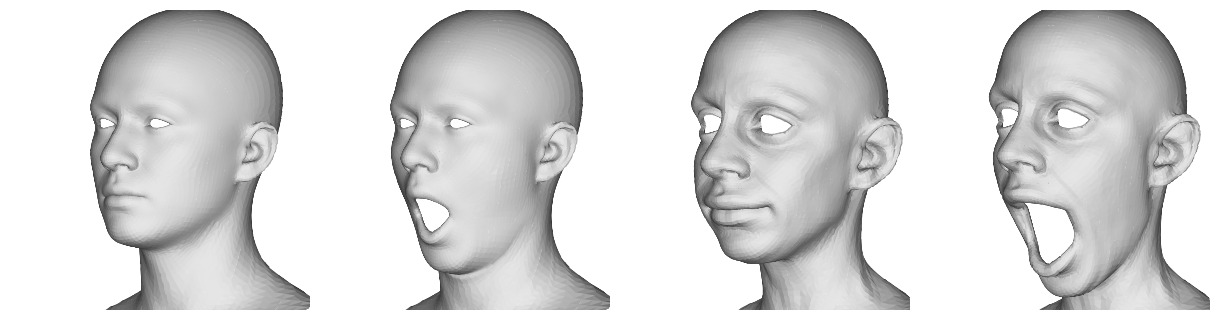

In [112]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .7

# mesh that you wanna render src_mesh.v, src_mesh.f
#v_list=[ src_mesh.v, src_mesh.motions[FRAME], tgt_mesh.v, V_transferred-V_transferred.mean(0)+tgt_mesh.v.mean(0)]
v_list=[ src_mesh.v, blendshapes[BS]+src_mesh.v, tgt_mesh.v, V_transferred + recenter]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ src_mesh.f ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,-40,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade',bg_black=True)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [ ]:


# # target rest pose
# V_T = get_triangle_basis(tgt_mesh.v, tgt_mesh.f)
# V_T_INV = np.linalg.inv(V_T)
# print(V_T_INV.shape)

# A = creat_A_csr_matrix_34(tgt_mesh.v, tgt_mesh.f, V_T_INV)
# # A = creat_A_csr_matrix(tgt_mesh.v, tgt_mesh.f, V_T_INV)
# print("A shape", A.shape)
# lu = lu_factor_ata(A)

# source rest pose ########################
V_S = get_triangle_basis(src_mesh.v, src_mesh.f)
print(V_S.shape) # (22288, 3, 3)
###########################################

# source posed ############################
#FRAME = 150
# V_S_H = get_triangle_basis(src_mesh.motions[FRAME], src_mesh.f)
# BS = 11
BS = 26
V_S_H = get_triangle_basis(blendshapes[BS]+src_mesh.v, src_mesh.f)
print(V_S_H.shape) # (22288, 3, 3)
###########################################

## a.k.a source transformation `S = V^~ @ V^-1`
V_S_INV = np.linalg.inv(V_S)
S = V_S_H @ V_S_INV
print(S.shape) # (22288, 3, 3)
###########################################


# target rest pose ########################
V_T = get_triangle_basis(tgt_mesh.v, tgt_mesh.f)
V_T_INV = np.linalg.inv(V_T)
print(V_T_INV.shape)
###########################################


# A^T A x^~ = A^T c
# x^~ = (A^T A)^-1 A^T c

Atb_0 = A.T @ S.transpose(0,2,1).reshape(-1)
print("A: ", A.shape)
# print("S: ", S.shape)
print("Atb: ", Atb.shape)

V_transferred = lu.solve(Atb_0).reshape(-1,3)
V_transferred = V_transferred[:tgt_mesh.v.shape[0]]
#print(V_transferred.shape)
#recenter = -V_transferred.mean(0)+tgt_mesh.v.mean(0)

# V_transferred = rescale(V_transferred, src_mesh.v)
# print(src_mesh.v.min(0), src_mesh.v.max(0))
# print(src_mesh.motions[FRAME].min(0), src_mesh.motions[FRAME].max(0))
# print(tgt_mesh.v.min(0), tgt_mesh.v.max(0))
# print(V_transferred.min(0), V_transferred.max(0))



(22288, 3, 3)
(22288, 3, 3)
(22288, 3, 3)
(22288, 3, 3)
A:  (200592, 100608)
S:  (22288, 3, 3)
Atb:  (100608,)
(33536, 3)
(11248, 3)


In [116]:
Atb_0 = A.T @ T
Atb_0.shape

NameError: name 'T' is not defined

(11248,) 1.0 0.0
(11248,) 0.0 0.0


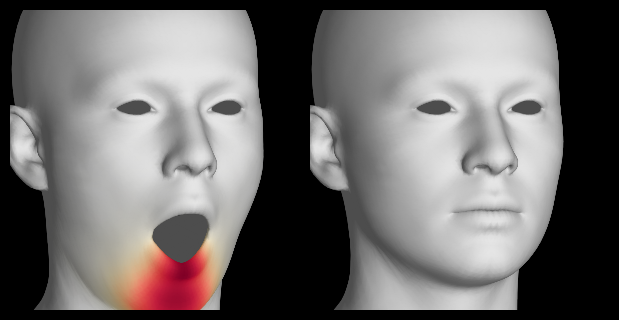

(11248,) 1.0 0.0
(11248,) 0.0 0.0


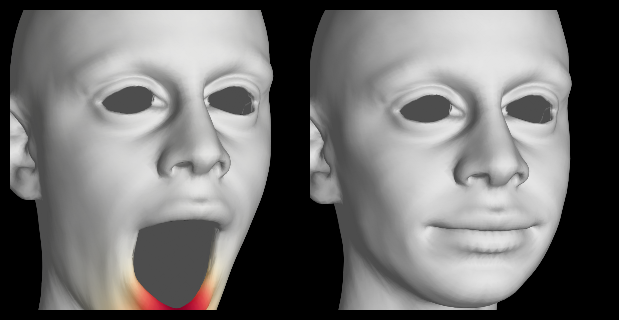

In [107]:

mesh_scale = 1
rot_list=[ [0,20,0] ]*len(v_list)

v_list1=[ 
        # src_mesh.motions[FRAME],
        blendshapes[BS]+src_mesh.v,
        src_mesh.v
    ]
f_list1=[ 
        src_mesh.f,
        src_mesh.f,
    ]
plot_mesh_gouraud(v_list1, f_list1, 
                     is_diff=True, diff_base=src_mesh.v, diff_revert=False,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

v_list2=[
    # V_transferred,
    V_transferred + recenter,
    tgt_mesh.v
    ]
f_list2=[ 
        tgt_mesh.f,
        src_mesh.f,
    ]
plot_mesh_gouraud(v_list2, f_list2, 
                     is_diff=True, diff_base=tgt_mesh.v, diff_revert=False,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

# Deformation Transfer using igl library
But more like delta mush..?

In [29]:

import igl
import numpy as np
import scipy.sparse.linalg as spla
from scipy.sparse import csr_array, csr_matrix, diags, vstack, hstack
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg import splu
from utils.ict_face_model import ICT_face_model
from easydict import EasyDict

tgt_mesh = EasyDict()
src_mesh = EasyDict()

print('loading meshes')
src_mesh.v, src_mesh.f = igl.read_triangle_mesh("_tmp/m02_model.obj")
print('\t src vertices:', src_mesh.v.shape, '\t faces:',src_mesh.f.shape) # (11248, 3) (22288, 3)

src_mesh.motions = np.load(r'_tmp\040.npy')
print('\t src vertices (posed):', src_mesh.motions.shape) # (219, 11248, 3)

newV, newF = igl.read_triangle_mesh("_tmp/m02_deformed-0.2.obj")
# newV, newF = igl.read_triangle_mesh("../002_mesh.obj")
newV = rescale(newV, src_mesh.v)

tgt_mesh.v = newV
tgt_mesh.f = newF
print('\t tgt vertices:', tgt_mesh.v.shape) # (219, 11248, 3)

ict = ICT_face_model()
blendshapes = ict.exp_basis[:,:11248]
print(blendshapes.shape)

loading meshes
	 src vertices: (11248, 3) 	 faces: (22288, 3)
	 src vertices (posed): (219, 11248, 3)
	 tgt vertices: (11248, 3)
(53, 11248, 3)


Laplacian operator can be expressed as
$$

In [22]:
def mesh_area(mesh):
    target_fv = mesh.v[mesh.f]

    AB = target_fv[:, :, 1] - target_fv[:, :, 0]
    AC = target_fv[:, :, 2] - target_fv[:, :, 0]
    area = 0.5 * np.linalg.norm(np.cross(AB, AC), axis=-1)
    area_diag = np.repeat(area[:, np.newaxis], 3, axis=-1).reshape(-1)
    area = diags(area_diag)
    return area


## Precomputes

In [122]:
# source ###############
S_G = igl.grad(src_mesh.v, src_mesh.f) # sparse matrix
S_M = igl.massmatrix(src_mesh.v, src_mesh.f)
S_A = mesh_area(src_mesh)
L_S = S_G.T @ S_A @ S_G                # Approx. Laplacian
# L_S = S_G.T @ S_G                      # Approx. Laplacian
S_N = igl.per_vertex_normals(src_mesh.v, src_mesh.f)

# target ###############
T_G = igl.grad(tgt_mesh.v, tgt_mesh.f) # sparse matrix
T_M = igl.massmatrix(tgt_mesh.v, tgt_mesh.f)
T_A = mesh_area(tgt_mesh)
L_T = T_G.T @ T_A @ T_G                 # Approx. Laplacian
# L_T = T_G.T @ T_G                      # Approx. Laplacian
T_N = igl.per_vertex_normals(tgt_mesh.v, tgt_mesh.f)

T_M_I=spla.inv(T_M)
S_M_I=spla.inv(S_M)


In [150]:
# get_centroids(x)
R, t = procrustes_(S_N, T_N)

In [153]:
((S_M @ T_M_I) @ (blendshapes[BS])).shape

(11248, 3)

## RUN

In [237]:
#FRAME=150
BS = 11
# BS = 26
BShape = blendshapes[11] + blendshapes[26]
# displacement ###############
D_S = (S_M @ T_M_I) @ (BShape)
# D_S = (src_mesh.motions[FRAME] - src_mesh.v)
# D_S = (S_M @ T_M_I) @ (BShape+src_mesh.v - S_N)
#D_S = (S_M @ T_M_I) @ ((BShape+src_mesh.v) @ R.T - src_mesh.v) 
# D_S = ((BShape+src_mesh.v) @ R.T - src_mesh.v) 
# D_S = BShape #@ R.T
# D_S = blendshapes[BS]

# solve displacement!
b = L_S @ D_S
A = L_T

x = spla.spsolve(A, b)

# scale
# x = (S_M @ T_M_I) @ x

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


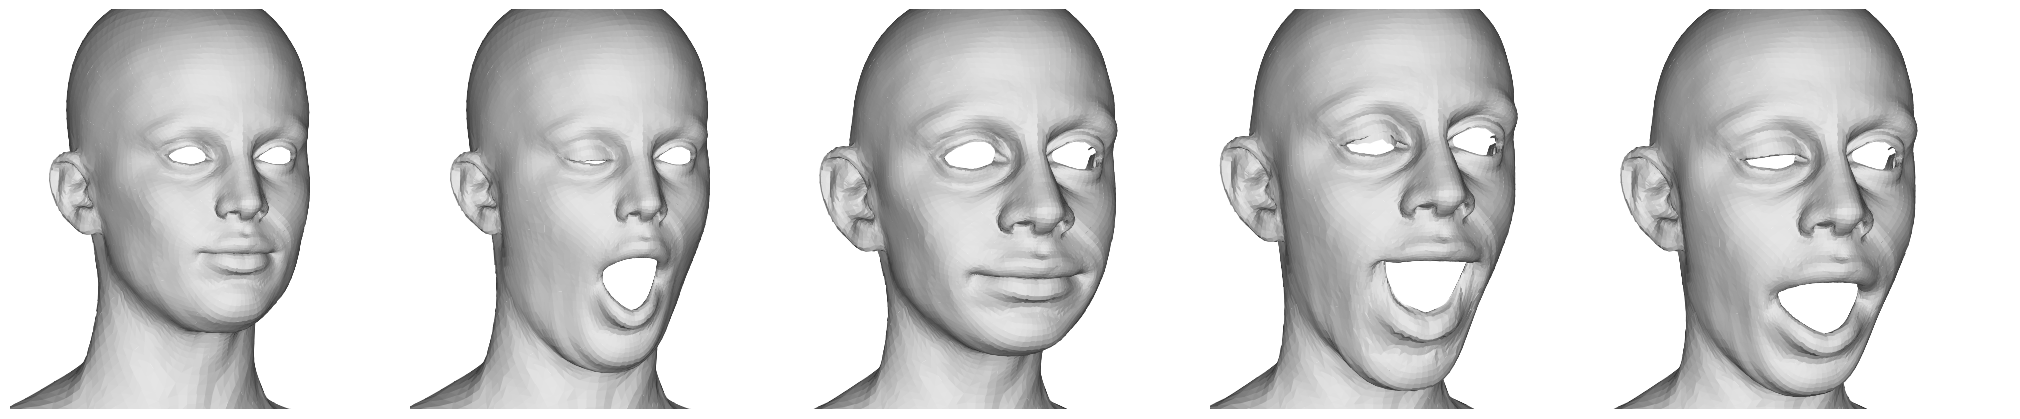

In [238]:
%load_ext autoreload
%autoreload 2
from matplotrender import *
# figure size
SIZE = 4
mesh_scale = 0.8
# mesh_scale=1.2

# mesh that you wanna render
v_list=[ 
        src_mesh.v, 
        # src_mesh.motions[FRAME], 
        src_mesh.v + BShape,
        tgt_mesh.v, 
        x + tgt_mesh.v, 
        # (T_M_I @ S_M @ x) + tgt_mesh.v,
        # (S_M_I @ T_M @ x) + tgt_mesh.v,
        # tgt_mesh.v + (S_M @ T_M_I) @ BShape,
        tgt_mesh.v + BShape,
        # x_new,
        # x_bc, 
        # x_bc_new
    ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ 
        src_mesh.f,
        src_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
    ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,20,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [239]:
qwe = trimesh.Trimesh(vertices=src_mesh.v + BShape, faces=src_mesh.f)
asd = trimesh.Trimesh(vertices=src_mesh.v, faces=src_mesh.f)
zxc = trimesh.Trimesh(vertices=tgt_mesh.v, faces=tgt_mesh.f)
_ = asd.export('source_restpose_mesh.obj')
_ = qwe.export('source_deformed_mesh.obj')
_ = zxc.export('target_restpose_mesh.obj')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


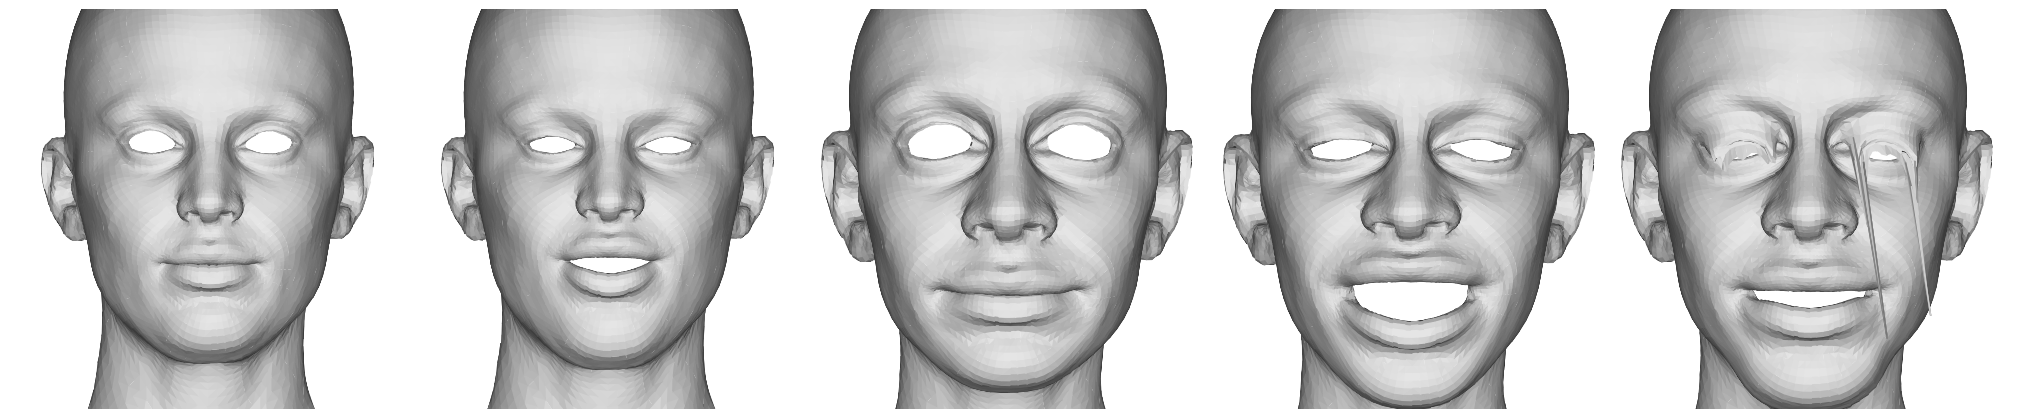

In [55]:
%load_ext autoreload
%autoreload 2
from matplotrender import *
# figure size
SIZE = 4
# mesh_scale = 0.6
mesh_scale=1

# mesh that you wanna render
v_list=[ 
        src_mesh.v, 
        src_mesh.motions[FRAME], 
        tgt_mesh.v, 
        x + tgt_mesh.v, 
        (x/x_len*s_len) + tgt_mesh.v, 
        # x_new,
        # x_bc, 
        # x_bc_new
    ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ 
        src_mesh.f,
        src_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
    ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

(11248,) 0.04440434231665857 3.2272350549557542e-09
(11248,) 1.0 0.0


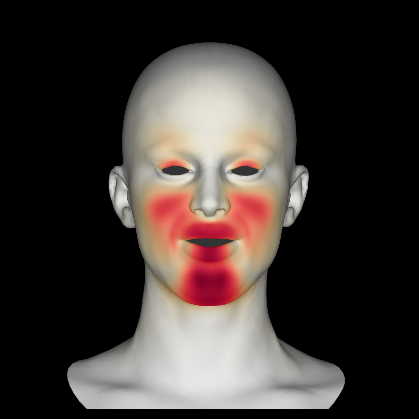

(11248,) 0.12307528615263995 0.0007814115155675175
(11248,) 1.0 0.0


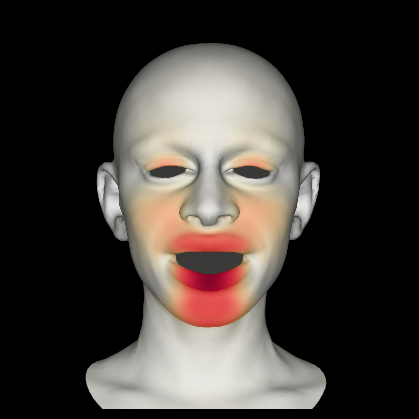

In [37]:

v_list1=[ 
        src_mesh.motions[FRAME],
    ]
diff_list1=[
        src_mesh.motions[FRAME]-src_mesh.v, 
    ]
v_list1=[ v*mesh_scale for v in v_list1]
f_list1=[ 
        src_mesh.f,
    ]
plot_image_array_grd(v_list1, f_list, 
                     diff_list1, is_diff=True, diff_base=src_mesh.v,
                     rot_list=rot_list, size=SIZE, mode='shade')

v_list2=[
    # x + tgt_mesh.v
    (x-x.mean(0,keepdims=True)) + tgt_mesh.v,
    ]
diff_list2=[
    # x
    (x-x.mean(0,keepdims=True)),
    ]
v_list2=[ v*mesh_scale for v in v_list2]
f_list1=[ 
        tgt_mesh.f,
    ]
plot_image_array_grd(v_list2, f_list, 
                     diff_list2, is_diff=True, diff_base=tgt_mesh.v,
                     rot_list=rot_list, size=SIZE, mode='shade')

In [149]:
def compute_average_distance(points, mode='np'):
    """Compute the average Euclidean distance from the origin for a set of points.

    Args
    -------
        points (np.ndarray / torch.tensor): [V, 3] A set of points.
        mode (str): choose between np (numpy) and torch

    Return
    -------
        average_distance (np/torch): Average Euclidean distance.
    """
    if mode=='np':
        distances = np.linalg.norm(points, axis=1)
        average_distance = np.mean(distances)
    else:
        distances = torch.linalg.norm(points, axis=1)
        average_distance = torch.mean(distances)
    return average_distance

def procrustes_(P, Q, LDM=None, mode='np'):
    """# Q = P@R.T+t
    [P->Q] Find the optimal rotation, translation, and scaling
    that aligns two sets of points P and Q minimizing using landmarks.
    
    Args
    -------
        P (np.ndarray): [V, 3] A set of source points.
        Q (np.ndarray): [V, 3] A set of corresponding target points.

    Returns
    ------- 
        R (np.ndarray): Rotation matrix (R)
        t (np.ndarray): translation vector (t)
        s (np.ndarray): scale factor (s)
    """
    if mode=='np':
        helper = np
    else:
        helper = torch
        
    if LDM is not None:
        P = P[LDM]
        Q = Q[LDM]
    
    # Calculate the centroids of the point sets
    centroid_P = helper.mean(P, axis=0)
    centroid_Q = helper.mean(Q, axis=0)
    
    # Center the points around the origin
    P_centered = P - centroid_P
    Q_centered = Q - centroid_Q

    # Compute the covariance matrix
    H = P_centered.T @ Q_centered

    # Perform Singular Value Decomposition
    U, S, Vt = helper.linalg.svd(H)
    
    # Compute the rotation matrix
    R = Vt.T @ U.T

    # Special reflection case
    if helper.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Compute the translation vector
    t = centroid_Q - R @ (centroid_P)

    return R, t

In [53]:
L_S

tensor(indices=tensor([[    0,     1,     2,  ...,  9679, 11043, 11247],
                       [    0,     1,     2,  ..., 11043, 11156, 11247]]),
       values=tensor([-1.0000, -1.0000, -1.0000,  ...,  0.0833,  0.0833,
                      -1.0000]),
       size=(11248, 11248), nnz=144976, layout=torch.sparse_coo)

In [51]:
L_S.coalesce()

tensor(indices=tensor([[    0,     0,     0,  ..., 11247, 11247, 11247],
                       [    0,     2,   171,  ..., 11239, 11246, 11247]]),
       values=tensor([-1.0000,  0.1667,  0.1667,  ...,  0.5000,  0.2500,
                      -1.0000]),
       size=(11248, 11248), nnz=78324, layout=torch.sparse_coo)

In [38]:
print(S_G)

  (415, 0)	57.88253904082016
  (2533, 0)	8.867121581495
  (6126, 0)	-59.046580155311176
  (11559, 0)	-7.721789893164439
  (13677, 0)	-58.21530879360827
  (16752, 0)	55.8769565664605
  (22703, 0)	-1.2658291731230547
  (24821, 0)	-57.036221116858904
  (28414, 0)	46.95048223036222
  (33847, 0)	-57.34852685029324
  (35965, 0)	-2.903993175503608
  (39040, 0)	47.03884828396855
  (44991, 0)	8.604447493639912
  (47109, 0)	15.729138329462055
  (50702, 0)	16.702876212056793
  (56135, 0)	14.826422053889791
  (58253, 0)	3.86029072684607
  (61328, 0)	20.335710727423205
  (2479, 1)	-87.77968016970478
  (4361, 1)	-85.46021798647645
  (11505, 1)	86.572520134433
  (15506, 1)	95.6490158623694
  (24767, 1)	-62.274398788208956
  (26649, 1)	21.913566447542635
  (33793, 1)	-53.216942397543164
  :	:
  (22274, 11245)	1.5931882898125063
  (33418, 11245)	-2.088281005953583
  (33419, 11245)	-3.7144426725808337
  (44562, 11245)	-5.341222700081844
  (55706, 11245)	-5.036607654840957
  (55707, 11245)	-3.61461085735

In [44]:
x = lsqr(L_T.numpy(), C[:,0].numpy())
# y = lsqr(L_T, C[:,0])[0]
# z = lsqr(L_T, C[:,0])[0]
# x = x.reshape(-1, 3)
# print(x.min(0), x.max(0))


# lu = lu_factor_ata(L_T)
# Atb = A.T @ S.reshape(-1)
# x = lu.solve(Atb)

TypeError: can't convert Sparse layout tensor to numpy.convert the tensor to a strided layout first.

In [30]:
def compute_face_gradient(V, F, f):
    grads = np.zeros((F.shape[0], 3))
    for i, face in enumerate(F):
        v0, v1, v2 = V[face]
        f0, f1, f2 = f[face]

        e1 = v1 - v0
        e2 = v2 - v0

        normal = np.cross(e1, e2)
        area = 0.5 * np.linalg.norm(normal)
        normal /= (2 * area + 1e-8)

        g = ((f1 - f0) * np.cross(normal, v2 - v0) +
             (f2 - f0) * np.cross(v0 - v1, normal)) / (2 * area + 1e-8)

        grads[i] = g

    return grads


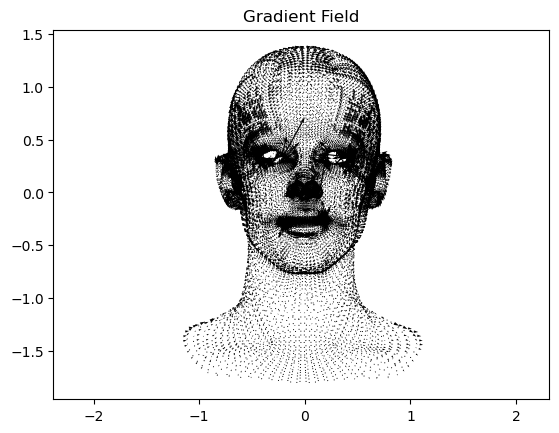

In [ ]:
import trimesh
import matplotlib.pyplot as plt

# 임의 메쉬 및 스칼라 함수
# mesh = trimesh.creation.icosphere()


vertices, faces = igl.read_triangle_mesh("_tmp/m02_model.obj")

mesh = trimesh.Trimesh(vertices=vertices,faces=faces)
V, F = mesh.vertices, mesh.faces
f = V[:, 2]  # z값을 스칼라 함수로 사용

grads = compute_face_gradient(V, F, f)

# 각 삼각형의 중심 계산
centroids = V[F].mean(axis=1)

# 시각화 (matplotlib)
# mesh.show()  # 3D 뷰

# 또는 2D quiver plot
plt.quiver(centroids[:,0], centroids[:,1], grads[:,0], grads[:,1])
plt.axis('equal')
plt.title('Gradient Field')
plt.show()


In [35]:
grads.shape

(22288, 3)

In [17]:
import scipy
import igl
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import  diags
# from meshplot import plot, subplot, interact

v, f = igl.read_triangle_mesh("_tmp/m02_model.obj")

## Find boundary vertices
e = igl.boundary_facets(f)
v_b = np.unique(e)

## List of all vertex indices
v_all = np.arange(v.shape[0])

## List of interior indices
v_in = np.setdiff1d(v_all, v_b)

## Construct and slice up Laplacian
l = igl.cotmatrix(v, f)
l_ii = l[v_in, :]
l_ii = l_ii[:, v_in]

l_ib = l[v_in, :]
l_ib = l_ib[:, v_b]

## Dirichlet boundary conditions from z-coordinate
z = v[:, 2]
bc = z[v_b]

## Solve PDE
z_in = spsolve(-l_ii, l_ib.dot(bc))

print(z_in.shape)
# plot(v, f, z)

(11036,)


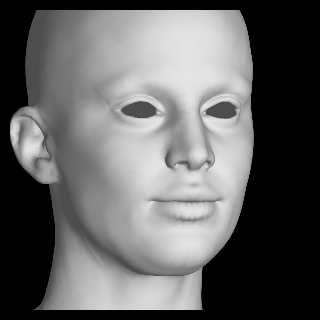

In [12]:
v_list2=[v]
diff_list2=[torch.tensor(z_in)]
f_list2=[f]
rot_list=[ [0,20,0] ]*len(v_list2)
plot_mesh_gouraud(v_list2, f_list2, 
                  #diff_list2, is_diff=True, diff_base=tgt_mesh.v,
                  rot_list=rot_list, size=3, mode='shade')

In [82]:

def smooth(vert, lap, loop=1, t=0.01):
    D_Inv = diags(1 / lap.diagonal())
    _lap = D_Inv @ lap
    
    # a = 1-t
    I_L = scipy.sparse.identity(lap.shape[0]) - _lap*t
    # I_L = (I_L*t).power(loop)
    for i in range(loop):
        I_L = I_L @ I_L
    
    vert = I_L @ vert
    return vert

In [92]:
l.toarray()
D_Inv = diags(1 / l.diagonal())
_lap = D_Inv @ l
# -_lap.toarray()
asd=  scipy.sparse.identity(_lap.shape[0])-_lap*0.53
# asd=asd*.1
# asd=asd @ asd
asd.toarray()

array([[0.47      , 0.        , 0.14466531, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.47      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14495706, 0.        , 0.47      , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.47      , 0.06337022,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05464159, 0.47      ,
        0.11676362],
       [0.        , 0.        , 0.        , ..., 0.        , 0.11341957,
        0.47      ]])

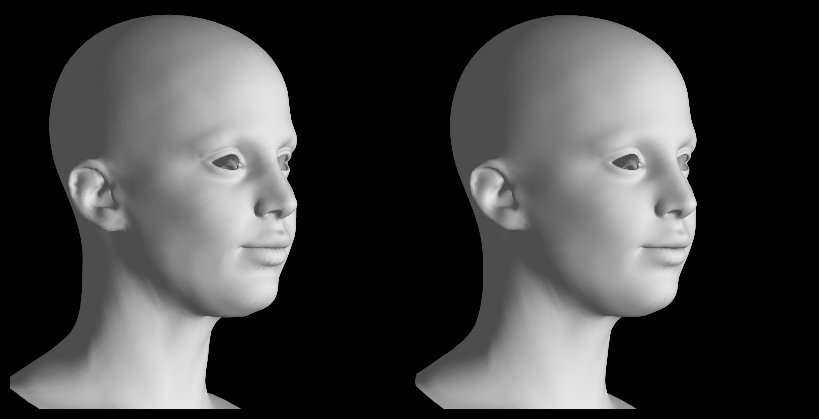

In [97]:
l = igl.cotmatrix(v, f)

vv = smooth(v, l, loop=4, t=0.1)
v_list2=[v, vv]

# v_list2=[v]

# diff_list2=[torch.tensor(z_in)]
f_list2=[f,f]
rot_list=[ [0,50,0] ]*len(v_list2)
plot_mesh_gouraud(v_list2, f_list2, 
                  #diff_list2, is_diff=True, diff_base=tgt_mesh.v,
                  rot_list=rot_list, size=4, mode='shade', mesh_scale=.7)

In [67]:
v-vv

array([[-1.14477360e-06, -9.75689049e-08,  3.06708775e-05],
       [ 9.67322233e-07, -1.03216951e-05, -8.57590897e-06],
       [-1.68050251e-06,  1.31471914e-05,  2.35897362e-05],
       ...,
       [ 1.25262577e-04, -4.69591310e-04, -6.41599250e-04],
       [ 6.75705609e-05, -4.91371724e-04, -5.97257610e-04],
       [ 2.90396888e-05, -5.47667548e-04, -5.52774756e-04]])